In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import time
torch.backends.cudnn.benchmark = True
import os
import polars as pl
from torch.utils.data import Dataset
import platform
from sklearn.model_selection import train_test_split


# New Dataset Loader

In [2]:
class CalorichPointNetDataset(Dataset):
    def __init__(self, point_net_dataset_path):
        """Constructor"""
        self.point_net_dataset = (
            pl.read_parquet(point_net_dataset_path)
            .select(["ring_radius_cal", "hits_xy_adjusted", "composite_event_id"])
            .filter(pl.col('ring_radius_cal').is_not_nan())
        )

    def __len__(self):
        """Size of the dataset"""
        return self.point_net_dataset.shape[0]

    def __getitem__(self, idx):
        """Get a particular item of the dataset"""
        
        start = time.time()

        noise = np.random.normal(0, 0.05, 50)
        noise = np.expand_dims(noise, 1)
        noise = torch.Tensor(noise)
        
        values = {
            "hits": (
                torch.cat((torch.tensor(self.point_net_dataset.select("hits_xy_adjusted").row(idx)).squeeze(), noise), -1).to(device)
            ),
            "ring_radius_cal":(
                torch.tensor(self.point_net_dataset.select("ring_radius_cal").row(idx)).squeeze().to(device)
            ),
            "composite_event_id":(
                self.point_net_dataset.select("composite_event_id").row(idx)
            )
        }

        end = time.time()


        return values

In [3]:
if platform.system() == 'Windows':
    dataset_path = r'C:\Users\merig\Documents\Projects\PointNet\data'
    dataset_file = 'point_net_[train_muons,cut_off_time=0.5,sample_size=50].parquet'

elif platform.system() == 'Darwin':
    dataset_path = r'C:\Users\merig\Documents\Projects\PointNet\data'
    dataset_file = 'point_net_[cut_off_time=0.5,sample_size=50].parquet'


In [4]:
dataset = CalorichPointNetDataset(os.path.join(dataset_path, dataset_file))

In [5]:
dataset.__len__()

1727827

In [6]:
dataset.__getitem__(0)

{'hits': tensor([[-3.8800e+01, -6.6570e+01, -9.0801e-02],
         [ 7.8200e+01,  4.2550e+01,  3.0233e-02],
         [ 7.8200e+01,  4.2550e+01, -9.6351e-03],
         [-2.8180e+02, -1.9800e+01, -2.2324e-03],
         [ 8.7200e+01, -9.7740e+01,  6.1927e-03],
         [-3.8800e+01, -6.6570e+01, -3.4749e-02],
         [ 7.8200e+01,  4.2550e+01, -3.1058e-02],
         [-2.4580e+02,  1.6726e+02, -2.5462e-02],
         [-1.8770e+02,  1.1521e+02, -6.0446e-02],
         [ 1.2320e+02, -9.7740e+01,  2.6703e-02],
         [ 9.6200e+01, -5.0980e+01,  3.9930e-02],
         [-1.5580e+02, -5.0980e+01,  9.9369e-02],
         [-6.5800e+01,  1.9844e+02, -4.9694e-02],
         [-5.6800e+01, -9.7740e+01,  4.6033e-02],
         [-2.3680e+02, -3.5390e+01, -1.1868e-01],
         [ 8.7200e+01, -9.7740e+01,  4.8037e-02],
         [-2.3680e+02, -3.5390e+01,  2.2187e-02],
         [-2.0980e+02, -1.9800e+01, -3.4908e-02],
         [-6.5800e+01,  1.9844e+02, -6.2106e-02],
         [-3.8800e+01, -6.6570e+01, -1.336

# DataLoader

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 10000
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
num_workers = 0
pin_memory = False


indices = list(range(dataset.__len__()))
split = int(np.floor(validation_split * dataset.__len__()))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers = num_workers, pin_memory = pin_memory)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers = num_workers, pin_memory = pin_memory)

In [8]:
train_loader

# PointNet

# PointNet for Regression

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetRegression_old(nn.Module):
    def __init__(self, num_features, num_output):
        super(PointNetRegression_old, self).__init__()
        
        # Input transformation network
        self.input_transform = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, kernel_size=1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        # Feature transformation network
        self.feature_transform = nn.Sequential(
            nn.Conv1d(1024, 512, kernel_size=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        
        # Fully connected layers for regression
        self.fc_regression = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_output)
        )

    def forward(self, x):
        batch_size = x.size(0)

        print(f'First stage x is {x.size()}')
        
        # Input transformation network
        x = self.input_transform(x)
        
        print(f'After input transform x is {x.size()}')
        
        # Global feature extraction
        x = torch.max(x, 2, keepdim=True)[0]

        print(f'After torch.max x is {x.size()}')
        
        # Feature transformation network
        x = self.feature_transform(x)

        print(f'After feature transform x is {x.size()}')
        
        # Global feature vector
        x = torch.max(x, 2, keepdim=False)[0]
        
        print(f'x before the fully connected layer is {x.size()}')

        # Fully connected layers for regression
        x = self.fc_regression(x)
        print(f'x after the fully connected layer is {x.size()}')
        
        return x

## PointNet for Regression II

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TNet(nn.Module):
    def __init__(self, k = 64):
        super(TNet, self).__init__()
        self.k = k

        self.conv_network = nn.Sequential(
            nn.Conv1d(k, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.fully_conn_network = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, k * k) # Add the equivalent to k * k
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv_network(x)
        x = nn.AdaptiveMaxPool1d(1)(x)
        x = x.view(batch_size, -1)
        x = self.fully_conn_network(x)
        identity_matrix = torch.eye(self.k, device=x.device).view(1, self.k * self.k).repeat(batch_size, 1)
        matrix = x + identity_matrix
        return matrix.view(batch_size, self.k, self.k)


class PointNetRegression(nn.Module):
    def __init__(self, num_features = 3, num_output = 1024):
        super(PointNetRegression, self).__init__()
        self.input_tnet = TNet(k=num_features)
        self.feature_tnet = TNet(k=64)
        
        # Input transformation network
        self.input_transform = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
            )

        
        # Feature transformation network
        self.feature_transform = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 512, kernel_size=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 1024, kernel_size=1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.conv1 = nn.Conv1d(num_features, 64, 1)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.conv3 = nn.Conv1d(64, 64, 1)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, num_output, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(num_output)
        
        # Fully connected layers for regression
        self.fc_regression = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_output)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # x = x.transpose(2, 1) # Apparently it is not necessary due to my loader
        
        # Input transformation network
        #print(f'Before input transformation TNet x is {x.size()}')
        input_tnet = self.input_tnet(x)
        #print(f'Input TNet is {x.size()}')
        x = torch.bmm(x.transpose(1, 2), input_tnet).transpose(1, 2)
        #print(f'After input transformation TNet Matrix Multiplication bmm x is {x.size()}')
        
        x = self.input_transform(x)
        #print(f'x after input_transform {x.size()} shape')
        
        # Feature transformation network
        feature_tnet = self.feature_tnet(x)
        x = torch.bmm(x.transpose(1, 2), feature_tnet).transpose(1, 2)
        #print(f'After feat transformation TNet Matrix Multiplication bmm x is {x.size()}')
        x = self.feature_transform(x)
       #print(f'x after feature_transform {x.size()} shape')

        # Global feature vector
        x = nn.AdaptiveMaxPool1d(1)(x)

        #print(f'x after adaptive pooling x has a {x.size()} shape')

        x = x.view(batch_size, -1)

        #print(f'x after view x has a {x.size()} shape')
        
        # Fully connected layers for regression

        x = self.fc_regression(x)

        #print(f'Final x {x.size()}')
        
        return x


# Trainer

In [11]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
	
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")


Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 3080


## Second Trainer

In [12]:
def best_trainer(model, criterion, optimizer, trainloader, validloader, epochs = 5, patience = 5, verbose = True):

    train_loss = []
    valid_loss = []
    start_time = 0
    end_time = 0
    print(device)
    start_time = time.time()
    model.to(device)
    end_time = time.time()
    # print(f'Model loading took {end_time - start_time:.3f} seconds')

    for epoch in range(epochs):

        train_batch_loss = 0
        valid_batch_loss = 0

        # Start the trainer

        for i, d in enumerate(trainloader):
            #print(f'Iteration {i + 1}')
            start_time = time.time()
            X = d['hits'].float() # float32
            y = d['ring_radius_cal'].float().to(device) # float32
            y = y.unsqueeze(1)
            end_time = time.time()
            # print(f'Data loading time: {end_time - start_time:.3f}')

            # Model is used
            start_time = time.time()
            optimizer.zero_grad()
            predictions = model(X)
            end_time = time.time()
            # print(f'The model took {end_time - start_time:.3f} seconds to run {X.type()} training dataset and cuda = {y.is_cuda} and {y.type()} ground truth dataset')

            # Loss
        
            start_time = time.time()
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            end_time = time.time()
            # print(f'The loss process took {end_time - start_time:.3f} seconds')
            train_batch_loss += loss.item()

        train_loss.append(loss.item() / len(train_loader))

        # Validation Loop

        with torch.no_grad(): # Stops graph computations

            for X_valid, y_valid in enumerate(validloader):
                start_time = time.time()
                X_valid = d['hits'].float().to(device) # float32
                y_valid = d['ring_radius_cal'].float().to(device) # float32
                y_valid = y_valid.unsqueeze(1)
                valid_preds = model(X_valid)
                loss = criterion(valid_preds, y_valid)
                end_time = time.time()
                # print(f'Validation loop took {end_time - start_time:.3f} seconds')

                valid_batch_loss += loss.item()

            valid_loss.append(loss.item() / len(validation_loader))

        if verbose:
            print(f'Epoch {epoch + 1}',
                  f'Train loss: {train_loss[-1]:.3f}'
                  f'Validation loss: {valid_loss[-1]:.3f}')
        
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
    
    return train_loss, valid_loss

### Parameters for Training

In [13]:
model = PointNetRegression(50, 1)
learning_rate = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 30

# Train

In [14]:
%%time
train_loss, valid_loss = best_trainer(model, 
                                 criterion, 
                                 optimizer, 
                                 train_loader,
                                 validation_loader,
                                 epochs=epochs, 
                                 patience=5,
                                 verbose=True)

cuda
Epoch 1 Train loss: 2.489Validation loss: 10.000
Epoch 2 Train loss: 2.215Validation loss: 8.646
Epoch 3 Train loss: 2.129Validation loss: 8.139
Epoch 4 Train loss: 2.241Validation loss: 8.553
Epoch 5 Train loss: 2.233Validation loss: 8.628
Epoch 6 Train loss: 2.121Validation loss: 8.207
Epoch 7 Train loss: 2.295Validation loss: 9.191
Epoch 8 Train loss: 2.098Validation loss: 8.249
Epoch 9 Train loss: 2.246Validation loss: 8.777
Epoch 10 Train loss: 2.203Validation loss: 8.650
Epoch 11 Train loss: 2.140Validation loss: 8.457
Epoch 12 Train loss: 2.207Validation loss: 8.291
Epoch 13 Train loss: 2.073Validation loss: 8.387
Epoch 14 Train loss: 2.243Validation loss: 7.813
Epoch 15 Train loss: 2.021Validation loss: 8.145
Epoch 16 Train loss: 2.161Validation loss: 8.572
Epoch 17 Train loss: 2.165Validation loss: 8.292
Epoch 18 Train loss: 1.950Validation loss: 7.560
Epoch 19 Train loss: 1.976Validation loss: 8.345
Epoch 20 Train loss: 2.155Validation loss: 8.144
Epoch 21 Train loss: 1.

In [17]:
torch.save(model.state_dict(), r'C:\Users\merig\Documents\Projects\PointNet\pointnet_II_MK2_states.pt')

In [18]:
torch.save(model, r'C:\Users\merig\Documents\Projects\PointNet\pointnet_II_MK2_model_only.pt')

# Predictions

In [23]:
print(device)
model.to(device)
trainTemplate = "epoch: {} test loss: {:.3f} test accuracy: {:.3f}"
training_start = time.time()
for epoch in range(epochs):
    print("[INFO] epoch: {}...".format(epoch + 1))
    epoch_start = time.time()
    train_losses, train_accs = [], []
    samples = 0

    model.train()

    for i, d in enumerate(train_loader):
        X = d['hits'].float().to(device) # Check why the change into a different datatype and why send it to device
        y = d['ring_radius_cal'].to(device) # Remember, I removed the .long() before .to(device) to get the decimal points (does not make sense)
        predictions = model(X)
        loss = criterion(predictions, y) # erased long() from y.long()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item() * y.size(0)) # Changed to append
        train_accs.append(torch.sub(predictions[0], y).mean().item()) # Added the () in sum()
        samples += y.size(0)

        print(f"Epoch: {epoch + 1} step: {i} with loss: {loss.item()} and accuracy: {train_accs[i]}")


cpu
[INFO] epoch: 1...


/Users/merigo/miniconda3/envs/591/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 step: 0 with loss: 33354.890625 and accuracy: -182.29331970214844
Epoch: 1 step: 1 with loss: 32972.20703125 and accuracy: -181.66702270507812
Epoch: 1 step: 2 with loss: 33298.81640625 and accuracy: -182.87208557128906
Epoch: 1 step: 3 with loss: 32850.35546875 and accuracy: -181.75552368164062
Epoch: 1 step: 4 with loss: 32173.66015625 and accuracy: -178.5542755126953
Epoch: 1 step: 5 with loss: 30839.78515625 and accuracy: -175.55686950683594
Epoch: 1 step: 6 with loss: 30696.392578125 and accuracy: -175.00392150878906
Epoch: 1 step: 7 with loss: 33110.17578125 and accuracy: -180.39144897460938
Epoch: 1 step: 8 with loss: 29401.443359375 and accuracy: -170.4647674560547
Epoch: 1 step: 9 with loss: 32157.677734375 and accuracy: -179.1426544189453
Epoch: 1 step: 10 with loss: 32352.0546875 and accuracy: -180.16629028320312
Epoch: 1 step: 11 with loss: 32702.724609375 and accuracy: -180.1944122314453
Epoch: 1 step: 12 with loss: 30728.96484375 and accuracy: -174.05487060546875

KeyboardInterrupt: 

# Tests

In [19]:
model_for_eval = PointNetRegression()
model_for_eval = torch.load(r'C:\Users\merig\Documents\Projects\PointNet\pointnet_II_MK2_model_only.pt')

In [20]:
model_for_eval.eval()

PointNetRegression(
  (input_tnet): TNet(
    (conv_network): Sequential(
      (0): Conv1d(50, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (fully_conn_network): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_feature

In [22]:
test_path = r'C:\Users\merig\Documents\Projects\PointNet\data\point_net_[test_muons,cut_off_time=0.5,sample_size=50].parquet'

In [23]:
test_dataset = CalorichPointNetDataset(test_path)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers = 0, pin_memory = False)

In [36]:
results = []
calc_ring_radius = []

with torch.no_grad():
            for i, d in enumerate(test_loader):
                X = d['hits'].float()
                y = d['ring_radius_cal'].float().to(device)
                y = y.unsqueeze(1)

                preds = model_for_eval(X)
                preds_arr = preds.detach().cpu().numpy()

                results.append(preds_arr)
                y_arr = y.detach().cpu().numpy()
                calc_ring_radius.append(y_arr)

In [38]:
results

[array([[182.05022],
        [181.23639],
        [184.20311],
        ...,
        [182.60504],
        [180.33867],
        [182.43588]], dtype=float32),
 array([[178.32616],
        [180.12433],
        [175.27219],
        ...,
        [178.9483 ],
        [181.47705],
        [173.71101]], dtype=float32),
 array([[149.92413],
        [179.425  ],
        [182.75212],
        ...,
        [179.74321],
        [183.49908],
        [178.01831]], dtype=float32),
 array([[180.86732],
        [178.64543],
        [184.79776],
        ...,
        [174.72818],
        [182.76047],
        [181.85057]], dtype=float32),
 array([[181.98082],
        [180.51071],
        [182.092  ],
        ...,
        [184.65001],
        [185.4192 ],
        [179.60252]], dtype=float32),
 array([[182.41129],
        [182.09639],
        [178.87279],
        ...,
        [181.84967],
        [173.12402],
        [181.40645]], dtype=float32),
 array([[182.31361],
        [169.68552],
        [183.30057],
 

In [44]:
len(calc_ring_radius)

44

In [42]:
results

[array([[182.05022],
        [181.23639],
        [184.20311],
        ...,
        [182.60504],
        [180.33867],
        [182.43588]], dtype=float32),
 array([[178.32616],
        [180.12433],
        [175.27219],
        ...,
        [178.9483 ],
        [181.47705],
        [173.71101]], dtype=float32),
 array([[149.92413],
        [179.425  ],
        [182.75212],
        ...,
        [179.74321],
        [183.49908],
        [178.01831]], dtype=float32),
 array([[180.86732],
        [178.64543],
        [184.79776],
        ...,
        [174.72818],
        [182.76047],
        [181.85057]], dtype=float32),
 array([[181.98082],
        [180.51071],
        [182.092  ],
        ...,
        [184.65001],
        [185.4192 ],
        [179.60252]], dtype=float32),
 array([[182.41129],
        [182.09639],
        [178.87279],
        ...,
        [181.84967],
        [173.12402],
        [181.40645]], dtype=float32),
 array([[182.31361],
        [169.68552],
        [183.30057],
 

In [39]:
results_2 = results.copy()

In [43]:
len(results_2)

44

In [ ]:
results_2.reshape()

In [47]:
entire_results = np.vstack(results)
entire_calc_ring = np.vstack(calc_ring_radius)

In [49]:
residuals = np.subtract(entire_calc_ring, entire_results)

In [50]:
residuals

array([[  2.5789185 ],
       [  7.548279  ],
       [ -1.1135712 ],
       ...,
       [  6.261627  ],
       [ -0.16621399],
       [-17.235672  ]], dtype=float32)

In [63]:
len(residuals.ravel().tolist())

431947

In [64]:
len(entire_results.ravel().tolist())

431947

In [65]:
len(entire_calc_ring.ravel().tolist())

431947

In [66]:
residuals_df = pd.DataFrame(list(zip(entire_results.ravel().tolist(), entire_calc_ring.ravel().tolist(), residuals.ravel().tolist())),
columns = ['Predicted', 'Theoretical', 'Residuals'])

In [67]:
residuals_df

,Predicted,Theoretical,Residuals
0,182.050217,184.629135,2.578918
1,181.236389,188.784668,7.548279
2,184.203110,183.089539,-1.113571
3,181.068176,182.075027,1.006851
4,176.847198,174.276138,-2.571060
...,...,...,...
431942,180.401169,185.126770,4.725601
431943,172.773422,184.649399,11.875977
431944,170.042099,176.303726,6.261627
431945,183.559662,183.393448,-0.166214


In [81]:
residuals_df['Residuals'].median()

3.1597900390625

<Axes: xlabel='Theoretical', ylabel='Residuals'>

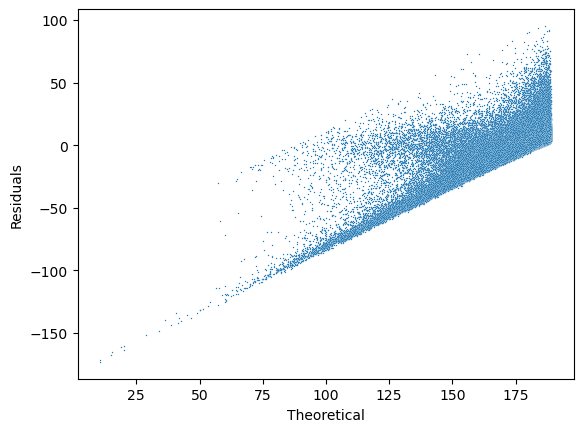

In [72]:
import seaborn as sbn

sbn.scatterplot(residuals_df, x = 'Theoretical', y = 'Residuals', s = 1)